In [330]:
import numpy as np
import matplotlib.pyplot as plt

In [331]:
K = 10
TRIALS = 1000
ITERATIONS = 20
MEAN_MEAN = 0
MEAN_STDDEV = 1
SAMPLE_STDDEV = 1
MEANS = np.random.normal(MEAN_MEAN, MEAN_STDDEV, K)
DATA = np.array([np.random.normal(mu, SAMPLE_STDDEV, TRIALS) for mu in MEANS])
EPSILON = 0.1

In [332]:
print(MEANS)
print(np.mean(DATA, axis=1))

[ 0.5883392  -0.22173509  0.15972945  0.5105824   0.56301706  0.31236945
 -0.9485688  -0.6007571   0.43815254  0.17621014]
[ 0.55760198 -0.26986811  0.13363173  0.49116182  0.56494885  0.31558961
 -1.01755961 -0.62488553  0.44904508  0.1892864 ]


In [354]:
class Env:
    def __init__(self, data, true_means, step=0):
        self.data = data
        self.true_means = true_means
        self.length = data.shape[1]
        self.step = step

class Bandit:
    def __init__(self, k, env, epsilon=0.1, ucb=False, init_estimates=0, iters=2000):
        self.k = k
        self.env = env
        self.epsilon = epsilon
        self.ucb = ucb
        self.init_estimates = init_estimates
        self.iters = iters
        self.counts = np.zeros(k)
        self.estimates = np.full(self.k, self.init_estimates, dtype=float)
        self.avg = np.zeros(env.length, dtype=float)
        self.opt = np.zeros(env.length, dtype=float)
    
    def act(self):
        x = np.random.random()
        if self.ucb:
            index = np.argmax(self.estimates + np.sqrt(np.log(1 + self.env.step) / (self.counts + 1e-5)))
        else:
            if x > self.epsilon:
                index = np.argmax(self.estimates)
            else:
                index = np.random.randint(0, self.k)

        reward = self.env.data[index, self.env.step]
        n = self.counts[index]
        mean = self.estimates[index]
        #print(reward, mean, n, (n*mean + reward)/(n+1))
        self.counts[index] += 1
        self.estimates[index] = (n*mean + reward)/(n+1)
        print(self.estimates)
        if self.env.step == 0:
            self.avg[self.env.step] = reward
            if index == np.argmax(self.env.true_means):
                self.opt[self.env.step] = 1
            else:
                self.opt[self.env.step] = 0
        else:
            self.avg[self.env.step] = (self.env.step * self.avg[self.env.step-1] + reward)/(self.env.step + 1)
            if index == np.argmax(self.env.true_means):
                self.opt[self.env.step] = (self.env.step * self.opt[self.env.step-1] + 1)/(self.env.step + 1)
            else:
                self.opt[self.env.step] = (self.env.step * self.opt[self.env.step-1])/(self.env.step + 1)
        self.env.step += 1
        
    def reset(self):
        self.counts = np.zeros(self.k)
        self.estimates = np.full(self.k, self.init_estimates, dtype=float)
        self.avg = np.zeros(self.env.length)
        self.opt = np.zeros(self.env.length)
        self.env.step = 0
        
    def run(self):
        avg = np.zeros((self.iters, self.env.length))
        opt = np.zeros((self.iters, self.env.length))
        for i in range(self.iters):
            for j in range(self.env.length):
                self.act()
                avg[i, j] = self.avg[j]
                opt[i, j] = self.opt[j]
            self.reset()
        avg = np.mean(avg, axis=0)
        opt = np.mean(opt, axis=0)
        return avg, opt

[-0.8081566133254876, 0, 0, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, 0.08502591501626999, 0, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, -0.05702354013576316, 0, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, -0.05702354013576316, 1.781145588954216, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, -0.05702354013576316, 1.519583386677489, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, -0.05702354013576316, 0.9792963132535869, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, 0.12543144616589558, 0.9792963132535869, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, 0.12543144616589558, 0.9677577340698095, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, 0.12543144616589558, 0.576764035561094, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, 0.12543144616589558, 0.5186532689291278, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, 0.12543144616589558, 0.37445095916490073, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, 0.12543144616589558, 0.37303927693665556, 0, 0, 0, 0, 0, 0, 0]
[-0.8081566133254876, 0.12543144616589558, 0.1374404973528

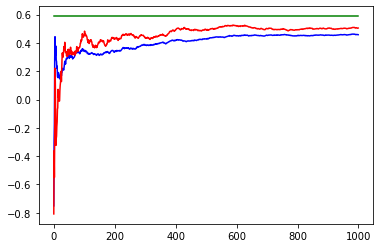

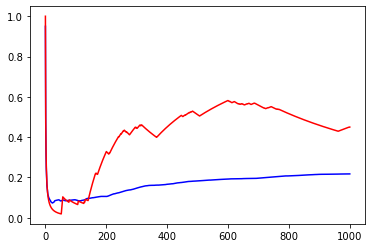

In [355]:
env = Env(DATA, MEANS)
bandit1 = Bandit(K, env, EPSILON, init_estimates=0, iters=ITERATIONS)
avg1, opt1 = bandit1.run()
plt.plot(avg1, color='blue')

bandit2 = Bandit(K, env, ucb=True, init_estimates=0, iters=ITERATIONS)
avg2, opt2 = bandit2.run()
plt.plot(avg2, color='red')
plt.plot(np.full(TRIALS, np.max(MEANS)), color='green')
plt.show()

plt.plot(opt1, color='blue')
plt.plot(opt2, color='red')
plt.show()

In [335]:
bandit3 = Bandit(K, env, EPSILON, init_estimates=0, iters=1)
for _ in range(bandit3.env.length):
    bandit3.act()
print(bandit3.env.true_means - MEANS)

[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 1 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0

In [346]:
x = np.full(10, 0)

In [347]:
x

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [348]:
x[1]=1
x

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])

In [353]:
x[1] = (2+x[1])/(1+1)
print(2+x[1], 1+1)
print(x[1])

3 2
1


In [351]:
x

array([0, 1, 0, 0, 0, 0, 0, 0, 0, 0])